# Predictive Analytics | Assignment 2

### source code repo
- https://github.com/kibambe-0167/time-series-analysis

In [1]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from datetime import datetime, timedelta
from pandas.plotting import lag_plot
from scipy.stats import skew, gmean
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
import os, sys
import random

# configs
sns.set_style(style='darkgrid')
np.random.seed(18)
random.seed(18)

In [2]:
def word_cloud(text: list):
  """text: list of text documents/sentences"""
  text = [str(i) for i in text]
  text = ' '.join(text).lower()
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

# data loading
- load data from different files
- combine the data into a single variable

#### summary
- the total number of samples if 420

In [3]:
BASE_DIR: str = "./data"

In [4]:
filesnames = os.listdir(BASE_DIR)
filesnames = [ f for f in filesnames if f.lower().endswith(".csv") ]
data = list()
for fn in filesnames:
  d = pd.read_csv(f"{BASE_DIR}/{fn}")
  data.append(d)
  
df = pd.concat(data, ignore_index=True)
print(df.shape)
df.head()

(420, 3)


,Date,Actual,Goal
0,Jun 28 2022,7225,8000
1,Jun 29 2022,8819,8000
2,Jun 30 2022,5082,8000
3,Jul 1 2022,6819,8000
4,Jul 2 2022,5603,8000


# data cleaning
#### summary
- The are no misssing or na or null data
- The section tries to perform data cleaning and preprocessing, before applying stats measures and visualizing the dataset

### check for null value
- there are no null values
- second block check if any of the columns have missing values
- showing rows with at least one null value

In [5]:
df.isnull().sum().to_frame().T 

,Date,Actual,Goal
0,0,0,0


In [6]:
df.isnull().any().sum()

np.int64(0)

In [7]:
df[df.isnull().any(axis=1)]  

,Date,Actual,Goal


### check for na values
- there are no na values
- second code check if any of the columns have missing values
- third block shows rows with atleast one missing value

In [8]:
df.isna().sum().to_frame().T

,Date,Actual,Goal
0,0,0,0


In [9]:
#  if any of the columns have missing values
df.isna().any().sum()

np.int64(0)

In [10]:
df[df.isna().any(axis=1)]  

,Date,Actual,Goal


### duplicate samples
- there is no duplicate samples in the datasets 

In [11]:
df.duplicated().sum()

np.int64(0)

### missing dates 
#### there are no missing dates, days where there is no date available
- check for missing dates
- if found add those dates to the datasets
- make those dates to have NaN values for Actual and Goal column

In [12]:
df['DateF'] = pd.to_datetime(df['Date'], format='%b %d %Y')

date_range = pd.date_range(start=df['DateF'].min(), end=df['DateF'].max(), freq='D')

df = df.set_index('DateF').reindex(date_range).reset_index()

# sort the df by date
df = df.sort_values('index')

df.head()

,index,Date,Actual,Goal
0,2022-05-31,May 31 2022,0,8000
1,2022-06-01,Jun 1 2022,0,8000
2,2022-06-02,Jun 2 2022,0,8000
3,2022-06-03,Jun 3 2022,1102,8000
4,2022-06-04,Jun 4 2022,1254,8000


### number of values with 0 for actual steps
- 13

In [13]:
df[ df['Actual'] == 0].shape

(13, 4)

In [14]:
df.isna().sum()

index     0
Date      0
Actual    0
Goal      0
dtype: int64

In [15]:
df.isnull().sum()

index     0
Date      0
Actual    0
Goal      0
dtype: int64

### check for the columns data type

In [16]:
df.dtypes

index     datetime64[ns]
Date              object
Actual             int64
Goal               int64
dtype: object

### info of the data

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   index   420 non-null    datetime64[ns]
 1   Date    420 non-null    object        
 2   Actual  420 non-null    int64         
 3   Goal    420 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 13.2+ KB


### show percentage of missing values
-  Returns percentage of missing values for each column

In [18]:
(df.isnull().sum() / len(df)) * 100

index     0.0
Date      0.0
Actual    0.0
Goal      0.0
dtype: float64

# descriptive statistics


#### Summary
- The 'Date' column is split into 3 column containing Month, Day and Year to better descriptive analysis
- I used statistical measures on the numeric columns to explain the relationship of the data in those columns, 
- Examples of stat measures used includes: std, variance, kurtosis, standard error, and many more

In [19]:
df.set_index("index", drop=False, inplace=True)
df.head()

,index,Date,Actual,Goal
index,,,,
2022-05-31,2022-05-31,May 31 2022,0,8000
2022-06-01,2022-06-01,Jun 1 2022,0,8000
2022-06-02,2022-06-02,Jun 2 2022,0,8000
2022-06-03,2022-06-03,Jun 3 2022,1102,8000
2022-06-04,2022-06-04,Jun 4 2022,1254,8000


In [20]:
def seperate_date(x, to_extract: int):
  """ to_extract
    0 : for month
    1 : for day
    2 : for year
  """
  x = str(x).lower().split(" ")
  if to_extract >= 0 and to_extract <= 2:
    x = x[to_extract].strip()
    # return numeric values for day and year column
    return int(x) if to_extract > 0 else x
  return "unknown"

#### Transform data for descriptive statistics

In [21]:
df_ds = df.copy()

# seperate the month, day, year into it on column for better descriptive analysis
df_ds['Month'] = df_ds['Date'].apply( lambda x: seperate_date(x, 0))
df_ds['Day'] = df_ds['Date'].apply( lambda x: seperate_date(x, 1))
df_ds['Year'] = df_ds['Date'].apply( lambda x: seperate_date(x, 2))

df_ds.head()

,index,Date,Actual,Goal,Month,Day,Year
index,,,,,,,
2022-05-31,2022-05-31,May 31 2022,0,8000,may,31,2022
2022-06-01,2022-06-01,Jun 1 2022,0,8000,jun,1,2022
2022-06-02,2022-06-02,Jun 2 2022,0,8000,jun,2,2022
2022-06-03,2022-06-03,Jun 3 2022,1102,8000,jun,3,2022
2022-06-04,2022-06-04,Jun 4 2022,1254,8000,jun,4,2022


In [22]:
# the data types of column of dataset
df_ds.dtypes

index     datetime64[ns]
Date              object
Actual             int64
Goal               int64
Month             object
Day                int64
Year               int64
dtype: object

In [23]:
# number of items in the dataset
df_ds.shape[0]

420

### Description of data

In [24]:
numeric_samples = df_ds[['Actual', 'Goal', 'Day', 'Year']]

numeric_samples.describe()

,Actual,Goal,Day,Year
count,420.000000,420.000000,420.000000,420.000000
mean,5674.140476,7682.142857,15.557143,2022.488095
std,2930.565439,613.717635,8.754355,0.500454
min,0.000000,6500.000000,1.000000,2022.000000
25%,3634.000000,8000.000000,8.000000,2022.000000
50%,5402.000000,8000.000000,15.500000,2022.000000
75%,7349.000000,8000.000000,23.000000,2023.000000
max,16611.000000,8000.000000,31.000000,2023.000000


### Sum of numeric columns

In [25]:
numeric_samples.sum().to_frame().T

,Actual,Goal,Day,Year
0,2383139,3226500,6534,849445


### Median of numeric columns
- a number in the middle of each column

In [26]:
numeric_samples.median().to_frame().T

,Actual,Goal,Day,Year
0,5402.0,8000.0,15.5,2022.0


### Mode
- mode of the numeric columns
- now able to show mode for Day, because about 24 values have the same frequency

In [27]:
numeric_samples[['Actual', 'Goal', 'Year']].mode()

,Actual,Goal,Year
0,0,8000,2022


### Variance
- of numeric columns

In [28]:
numeric_samples.var().to_frame().T

,Actual,Goal,Day,Year
0,8.588214e+06,376649.335152,76.638732,0.250455


### Z-Score
- of numeric columns

In [29]:
(numeric_samples - numeric_samples.mean() ) / numeric_samples.std()

,Actual,Goal,Day,Year
index,,,,
2022-05-31,-1.936193,0.517921,1.764020,-0.975304
2022-06-01,-1.936193,0.517921,-1.662846,-0.975304
2022-06-02,-1.936193,0.517921,-1.548617,-0.975304
2022-06-03,-1.560156,0.517921,-1.434388,-0.975304
2022-06-04,-1.508289,0.517921,-1.320159,-0.975304
...,...,...,...,...
2023-07-20,0.927759,-1.926200,0.507503,1.022880
2023-07-21,0.095497,-1.926200,0.621731,1.022880
2023-07-22,1.322564,-1.926200,0.735960,1.022880


### Co-efficient of covariance

to show how the values are around the mean
- high value tell that, more values are around the mean
- lower value tell, that values are far from the mean


In [30]:
cov = numeric_samples.std() / numeric_samples.mean()

print("MEANS: \n", numeric_samples.mean().to_frame().T)
print("\nCoefficient variance: \n\n", cov.to_frame().T)


MEANS: 
         Actual         Goal        Day         Year
0  5674.140476  7682.142857  15.557143  2022.488095

Coefficient variance: 

      Actual      Goal       Day      Year
0  0.516477  0.079889  0.562723  0.000247


### Standard error
- show how far the sample data is from the populations data

In [31]:
std_err = numeric_samples.apply(lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
std_err.to_frame().T

,Actual,Goal,Day,Year
0,142.996951,29.946354,0.427169,0.02442


### Confidence level

In [32]:
conf = .95
m = numeric_samples.mean()
n = numeric_samples.shape[0]
stderr = stats.sem(numeric_samples)
interval = stderr * stats.t.ppf( ( 1 + conf ) / 2.0, n - 1)
# 
(n - interval).round(3)

array([138.919, 361.136, 419.16 , 419.952])

### Kurtosis
- a statistical measure that describes the tails of a distribution of data


In [33]:
numeric_samples.kurtosis().to_frame().T

,Actual,Goal,Day,Year
0,1.024538,0.002262,-1.175325,-2.007296


### Skewness
- explains how the lopsided the data is
- positive : means the data is skewed to the right
- negative : means the data is skewed to the left


In [34]:
numeric_samples.apply(skew).to_frame().T

,Actual,Goal,Day,Year
0,0.673831,-1.409959,0.027705,0.047633


### Ranges
- show the difference the min value and the max value in each column

In [35]:
(numeric_samples.max() - numeric_samples.min()).to_frame().T

,Actual,Goal,Day,Year
0,16611,1500,30,1


### Geometric mean
- is the average value that show the central tendency of set of numbers, by finding the products of the numbers sets

In [36]:
numeric_samples.apply(gmean).to_frame().T

,Actual,Goal,Day,Year
0,0.0,7655.633419,12.06832,2022.488033


In [37]:
numeric_samples.head()

,Actual,Goal,Day,Year
index,,,,
2022-05-31,0,8000,31,2022
2022-06-01,0,8000,1,2022
2022-06-02,0,8000,2,2022
2022-06-03,1102,8000,3,2022
2022-06-04,1254,8000,4,2022


### mean absolute value
- the average of the absolute deviation from the central point

In [38]:
numeric_samples.apply(lambda x: np.mean(np.abs(x - np.mean(x))), axis=0).to_frame().T

,Actual,Goal,Day,Year
0,2253.75051,501.003401,7.557143,0.499717


# data visualisation

In [39]:
df.head()

,index,Date,Actual,Goal
index,,,,
2022-05-31,2022-05-31,May 31 2022,0,8000
2022-06-01,2022-06-01,Jun 1 2022,0,8000
2022-06-02,2022-06-02,Jun 2 2022,0,8000
2022-06-03,2022-06-03,Jun 3 2022,1102,8000
2022-06-04,2022-06-04,Jun 4 2022,1254,8000


### Actual Steps Visualisation

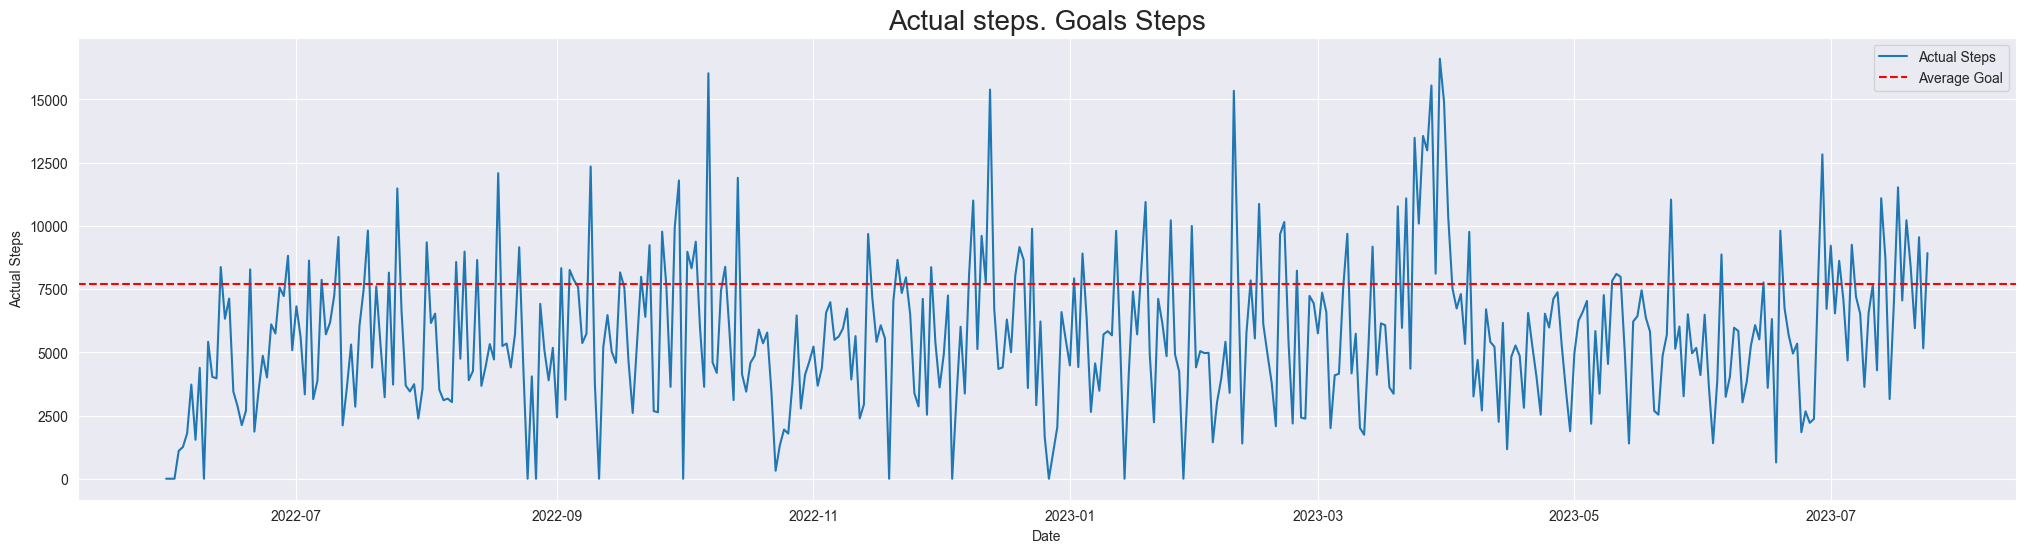

In [40]:
plt.figure(figsize=(25, 6))
plt.plot(df.index, df['Actual'], label='Actual Steps')
plt.axhline(df['Goal'].mean(), color='r', linestyle='--', label='Average Goal')
plt.xlabel('Date')
plt.ylabel('Actual Steps')
plt.title('Actual steps. Goals Steps', fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

### Actual Steps Scatter plot

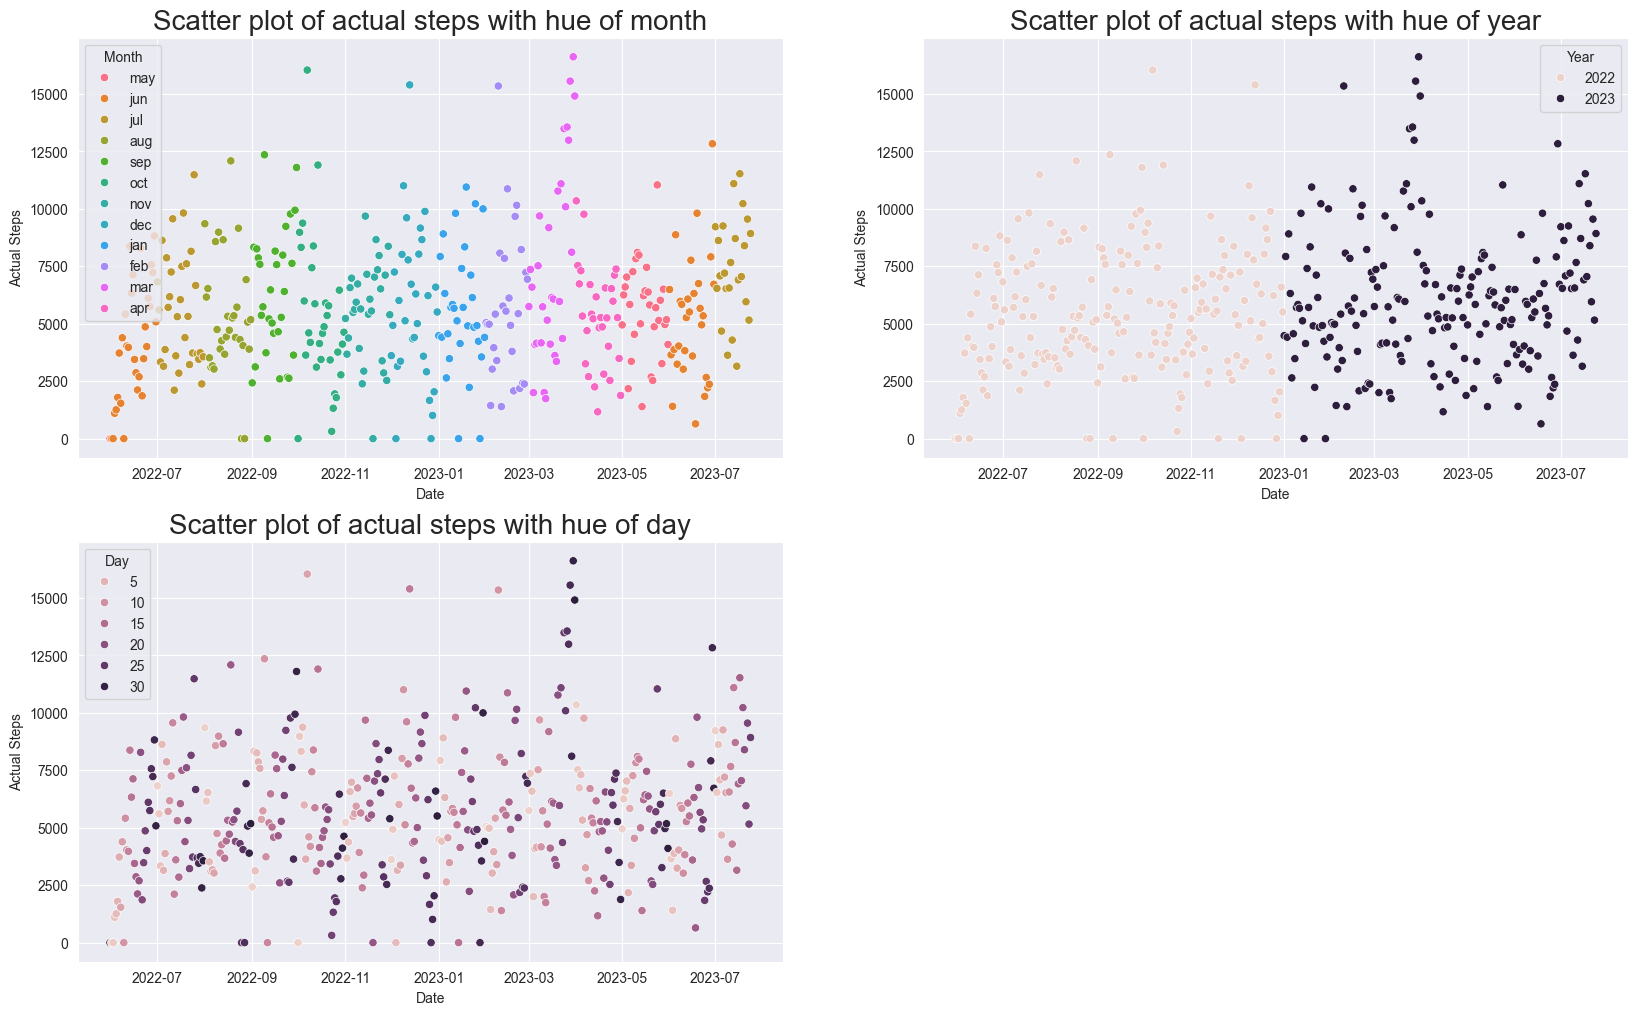

In [109]:
plt.figure(figsize=(20,12))

plt.subplot(2, 2, 1)
sns.scatterplot(data=df_ds, x= df_ds.index, y='Actual', hue='Month')
plt.title("Scatter plot of actual steps with hue of month", fontsize=20)
plt.ylabel("Actual Steps")
plt.xlabel("Date")

plt.subplot(2, 2, 2)
sns.scatterplot(data=df_ds, x= df_ds.index, y='Actual', hue='Year')
plt.title("Scatter plot of actual steps with hue of year", fontsize=20)
plt.ylabel("Actual Steps")
plt.xlabel("Date")

plt.subplot(2, 2, 3)
sns.scatterplot(data=df_ds, x= df_ds.index, y='Actual', hue='Day')
plt.title("Scatter plot of actual steps with hue of day", fontsize=20)
plt.ylabel("Actual Steps")
plt.xlabel("Date")

plt.show()

### Months frequencies

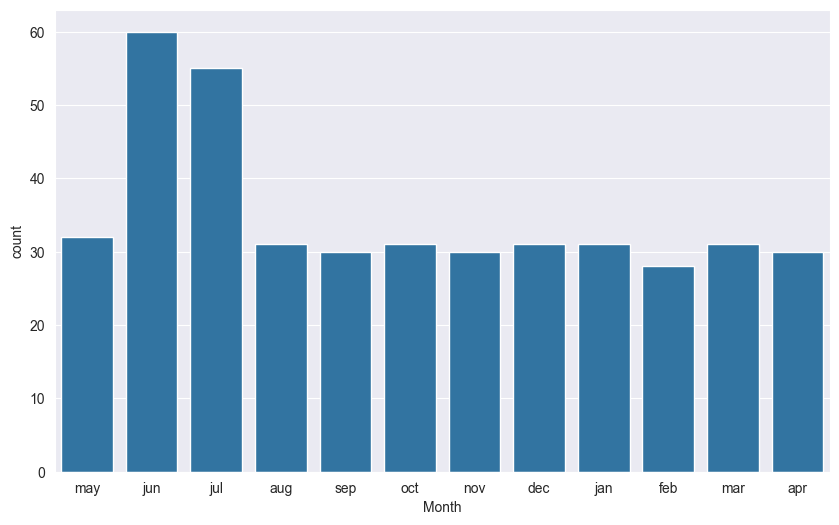

In [108]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df_ds['Month'])
plt.show("Count of months")
plt.show()

### Year

### word cloud for months from the dataset
- June and July are the most common months in the dataset
- did it for fun

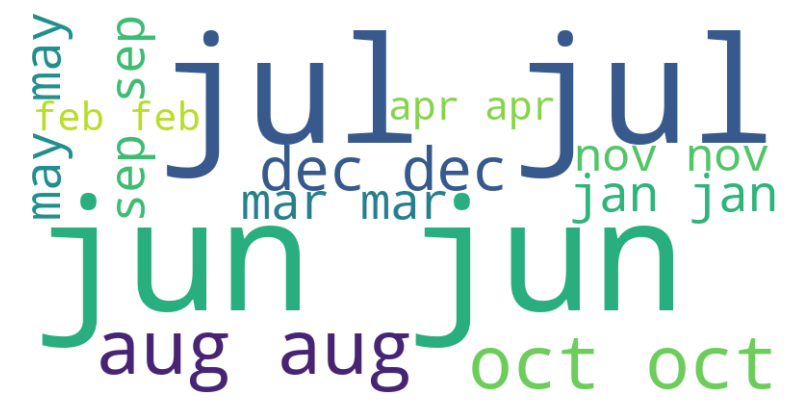

In [41]:
wc = df_ds['Month'].values
word_cloud(wc)

### moving average (simple)
- helps to highlight long terms trends in the steps taken
- to smooth out short term fluctuations from the dataset
- its calculate average of a subset of data over a period of time


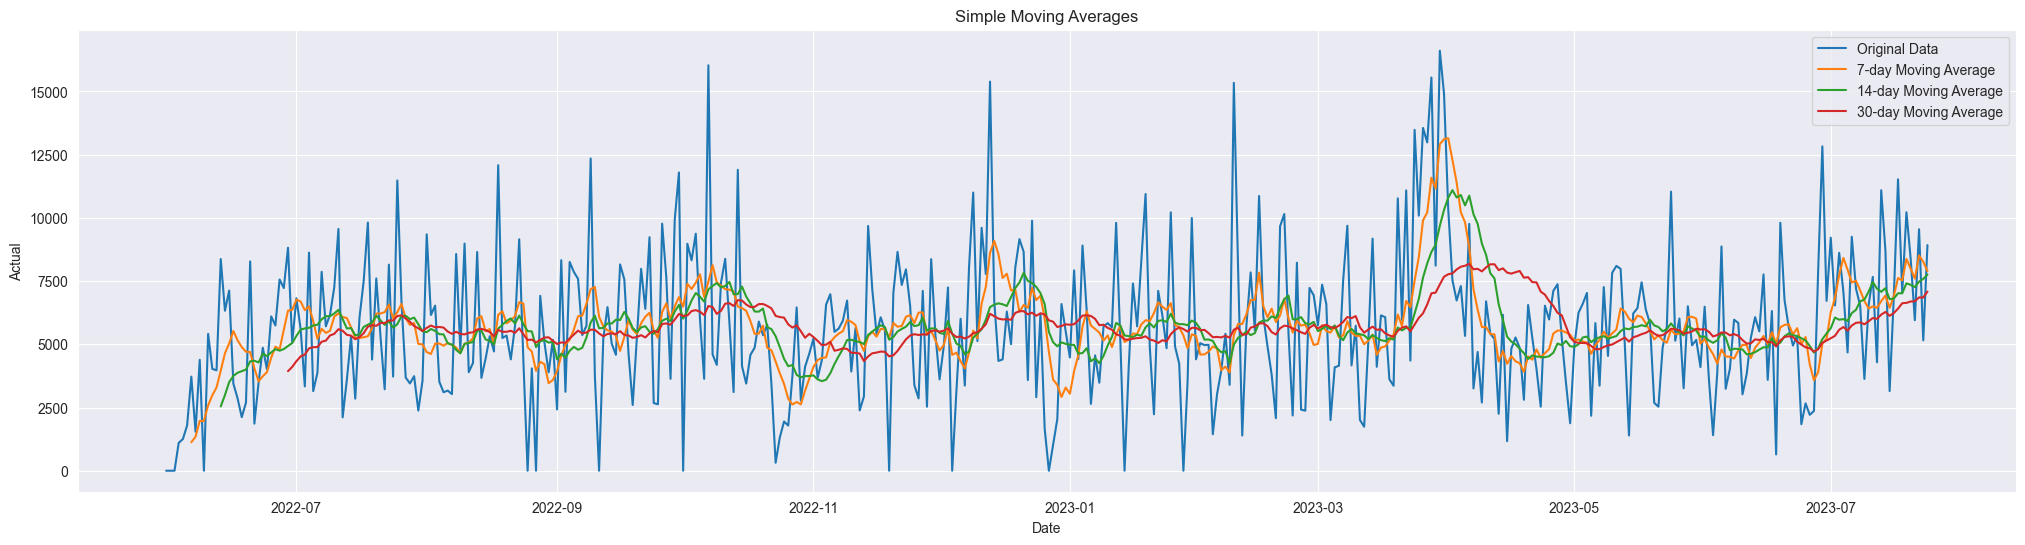

In [42]:
# 7-day && 30-day moving averages | can calculate for std
df['7_day_MA'] = df['Actual'].rolling(window=7).mean()
df['14_day_MA'] = df['Actual'].rolling(window=14).mean()
df['30_day_MA'] = df['Actual'].rolling(window=30).mean()

plt.figure(figsize=(25, 6))
plt.plot(df.index, df['Actual'], label='Original Data')
plt.plot(df.index, df['7_day_MA'], label='7-day Moving Average')
plt.plot(df.index, df['14_day_MA'], label='14-day Moving Average')
plt.plot(df.index, df['30_day_MA'], label='30-day Moving Average')
plt.legend()
plt.title('Simple Moving Averages')
plt.xlabel('Date')
plt.ylabel('Actual')
plt.grid(True)
plt.show()


df.drop(columns=['7_day_MA','14_day_MA', '30_day_MA'], inplace=True)

### Autocorrelation function - data is stationary
- The ACF measures the correlation between a time series and lagged versions of itself over different time lags. 
- It helps to identify the extent of a relationship between observations in the time series at different points in time.
- useful for identifying repeating patterns, trends, and seasonality in time series data.

### Partial Autocorrelation function
- The PACF measures the correlation between a time series and its lagged version, controlling for the correlations of all shorter lags. 
- In other words, it shows the direct relationship between an observation and its lagged observations, removing the influence of intermediate lags.
- The PACF is often used to determine the appropriate number of lags to include in an autoregressive (AR) model.

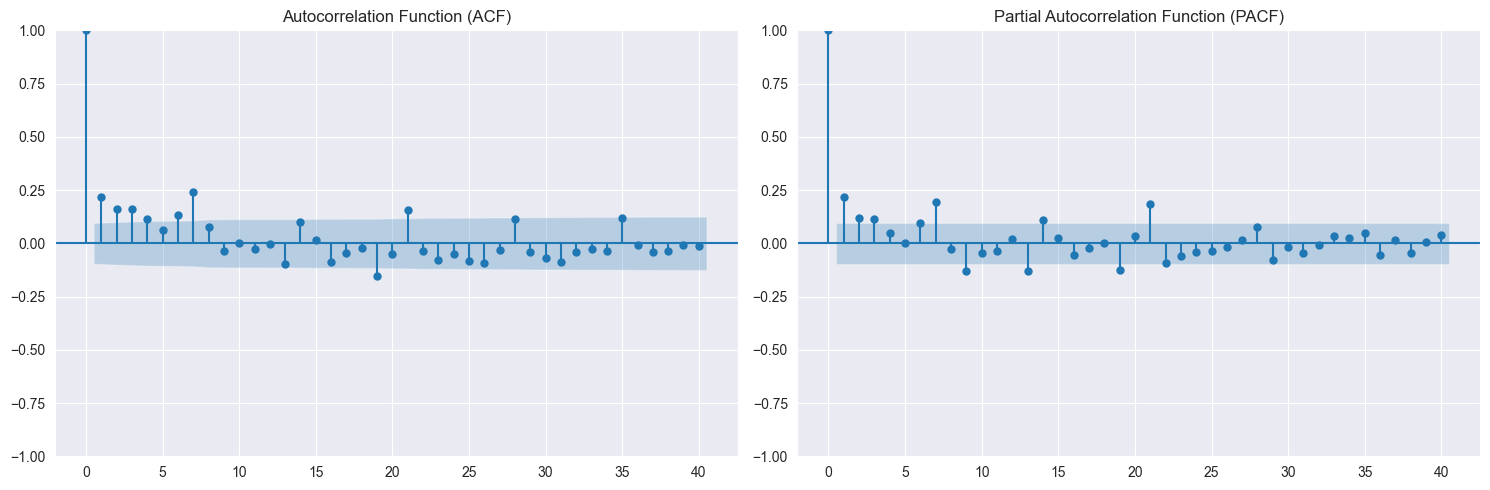

In [43]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plot_acf(df[['Actual']], lags=40, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

plt.subplot(1, 2, 2)
plot_pacf(df[['Actual']], lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

### Seasonality and trends decomposition

- Seasonal Decomposition, separates the time series into three components, trend (long-term progression), seasonal (periodic fluctuations), and residual (random noise).
- Trend Analysis, helps to identify and visualize the long-term trend in the data

#### seasonal
- there is a trend with the data plot number 3, showing a cyclical pattern that repeat in the data

#### trend
- plot 2, its follows the pattern of the actual values, but smoothed out

#### residual
- plot 4, show the data that is left after removing the trends and the seasonality from the actual steps

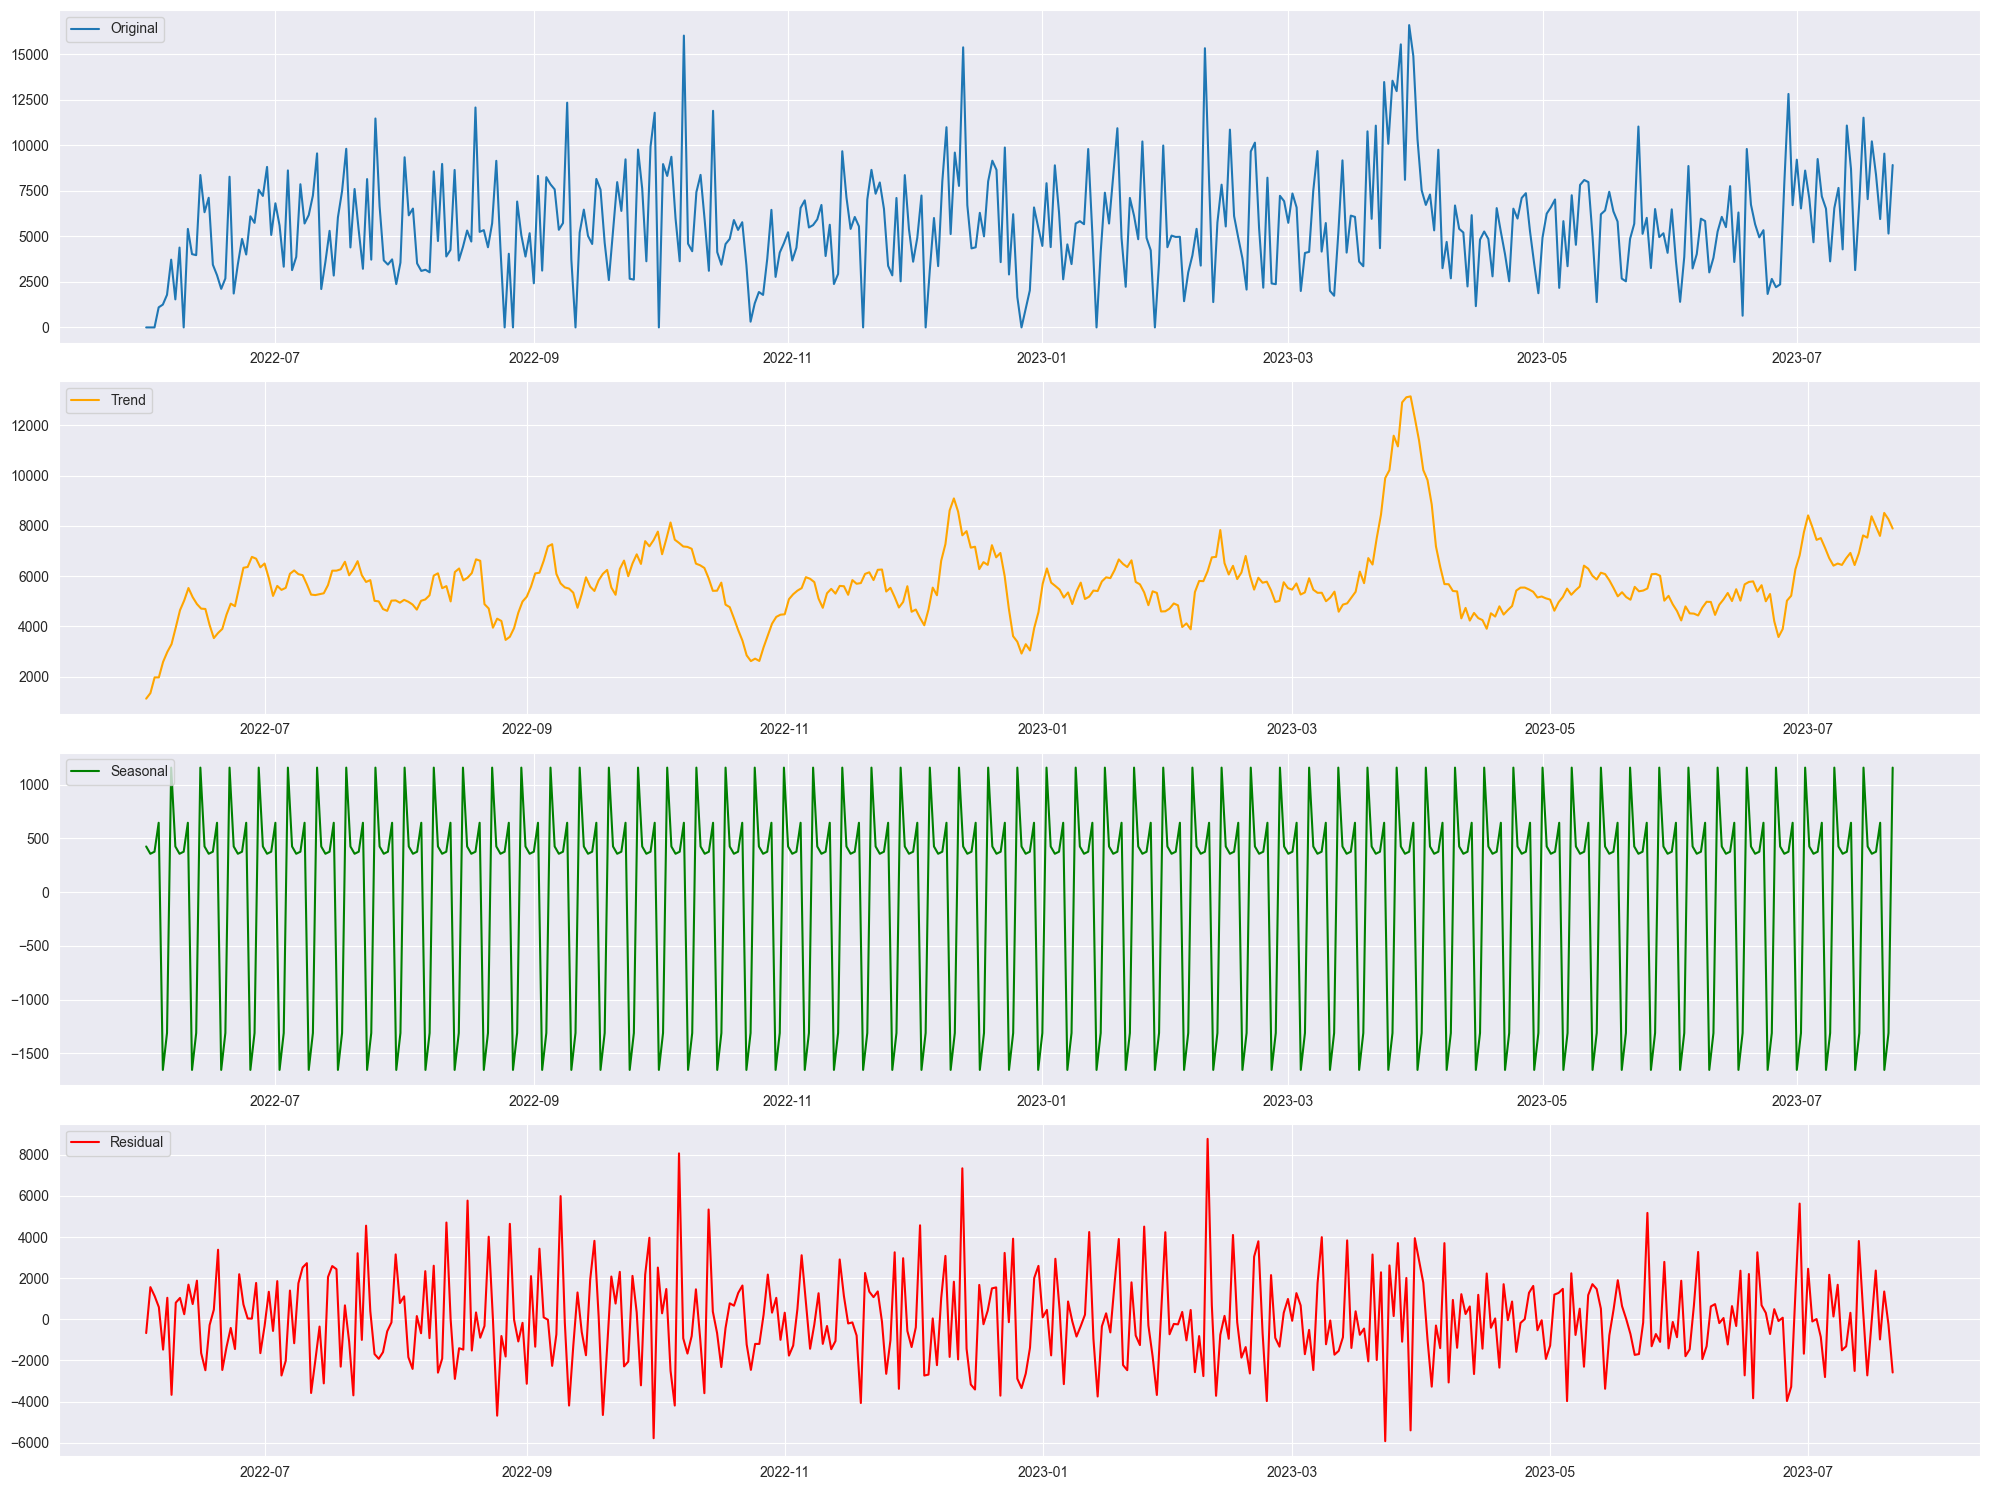

In [44]:
# decompose the actual values
decomposition = seasonal_decompose(df['Actual'], model='additive')

# extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(20, 15))
# plt.title("hbjnkm")

plt.subplot(411)
plt.plot(df['Actual'], label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(trend, label='Trend', color='orange')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residual, label='Residual', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

### Stationarity tests -> Actual steps data is stationary
- to determine if the time series data is stationary or not
- A stationary time series has constant statistical properties over time, including mean, variance, and autocorrelation

#### Augmented dickey fuller 
- H0, steps data is non-stationary
- H1, time series is stationanry
- ADF value = -4.831054414326103
- p-value = 0.00004741516040666676

#### KPSS
- H0, actual steps data is stationary
- H1, actual steps data is not stationary
- KPSS value = 0.3665598925848031
- p-value = 0.09156901181689521


In [45]:
# value of less than 0.05 means the data is stationary
# augumented DF
adf_result = adfuller(df['Actual'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -4.831054414326103
p-value: 4.741516040666676e-05


In [46]:
kpss_result = kpss(df['Actual'], regression='c')
print(f'KPSS Statistic: {kpss_result[0]}')
print(f'p-value: {kpss_result[1]}')

KPSS Statistic: 0.3665598925848031
p-value: 0.09156901181689521


In [47]:
test_results = pd.DataFrame({
    'Test': ['ADF', 'KPSS'],
    'Test Statistic': [adf_result[0], kpss_result[0]],
    'p-value': [adf_result[1], kpss_result[1]],
    'Conclusion': ['Stationary' if adf_result[1] < 0.05 else 'Non-Stationary',
                   'Stationary' if kpss_result[1] >= 0.05 else 'Non-Stationary']
})

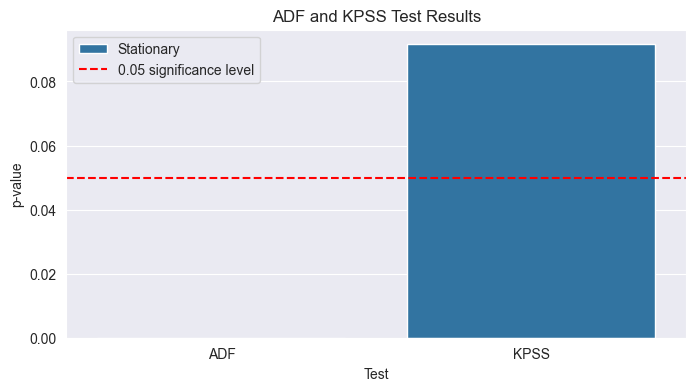

In [48]:
plt.figure(figsize=(8, 4))
sns.barplot(x='Test', y='p-value', hue='Conclusion', data=test_results)
plt.axhline(0.05, color='red', linestyle='--', label='0.05 significance level')
plt.title('ADF and KPSS Test Results')
plt.ylabel('p-value')
plt.legend()
plt.show()

### Summary statistics by time periods
- Daily, weekly, monthly, or yearly summaries
- helps to understand how the steps data behaves over different time scales
- the plots are only for the monthly and weekly, as the yearly is ony 2 samples and daily is the same as the actual data

In [49]:
# Daily 
daily_summary = df['Actual'].resample('D').agg(['mean', 'sum', 'median', 'std'])
# Weekly 
weekly_summary = df['Actual'].resample('W').agg(['mean', 'sum', 'median', 'std'])
# Monthly 
monthly_summary = df['Actual'].resample('ME').agg(['mean', 'sum', 'median', 'std'])
# Yearly
yearly_summary = df['Actual'].resample('YE').agg(['mean', 'sum', 'median', 'std'])

In [50]:
yearly_summary

,mean,sum,median,std
index,,,,
2022-12-31,5355.465116,1151425,5228.0,2858.719332
2023-12-31,6008.360976,1231714,5709.0,2974.450992


In [51]:
# plt.figure(figsize=(25, 6))
# plt.plot( daily_summary.index, daily_summary['mean'] -2, label="Mean Daily Summary" )
# plt.plot( daily_summary.index, daily_summary['std'], label="Std Daily Summary" )
# plt.plot( df.index, df['Actual'] + 1, label="Actual Steps" )

# plt.title("Daily statistical summary, using std and mean - (all std are nan, no idea why)", fontsize=20)
# plt.legend()
# plt.grid(True)
# plt.show()

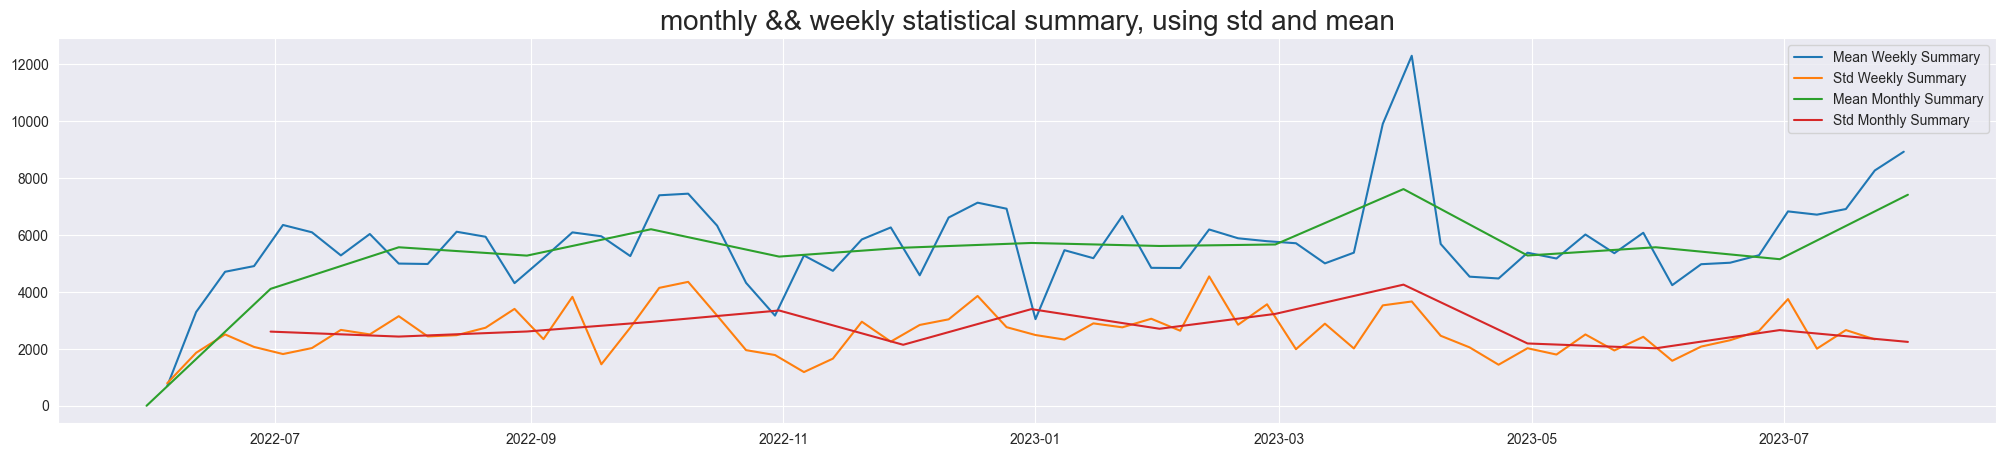

In [52]:
plt.figure(figsize=(25, 5))
# plt.plot( daily_summary.index, daily_summary['mean'], label="Mean Daily Summary" )
plt.plot( weekly_summary.index, weekly_summary['mean'], label="Mean Weekly Summary" )
plt.plot( weekly_summary.index, weekly_summary['std'], label="Std Weekly Summary" )
plt.plot( monthly_summary.index, monthly_summary['mean'], label="Mean Monthly Summary" )
plt.plot( monthly_summary.index, monthly_summary['std'], label="Std Monthly Summary" )

plt.title("monthly && weekly statistical summary, using std and mean", fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

### Volatility measures
- used to to capture the variability or uncertainty over time

##### Historical volatility
- historical volatility can help identify periods of inconsistency or changes in behavior (e.g., vacation periods, illness)
- represent the standard deviation of the daily changes (or returns) in step count over a specified period. 
- High volatility would indicate significant fluctuations in the daily step count, while low volatility 

##### Historical volatility
- Exponentially weighted moving average (EWMA) volatility
- capture the variability of the daily changes in step count but would place more weight on recent days
- useful if you're interested in identifying recent increases or decreases in activity levels, perhaps in response to a new exercise routine or lifestyle change

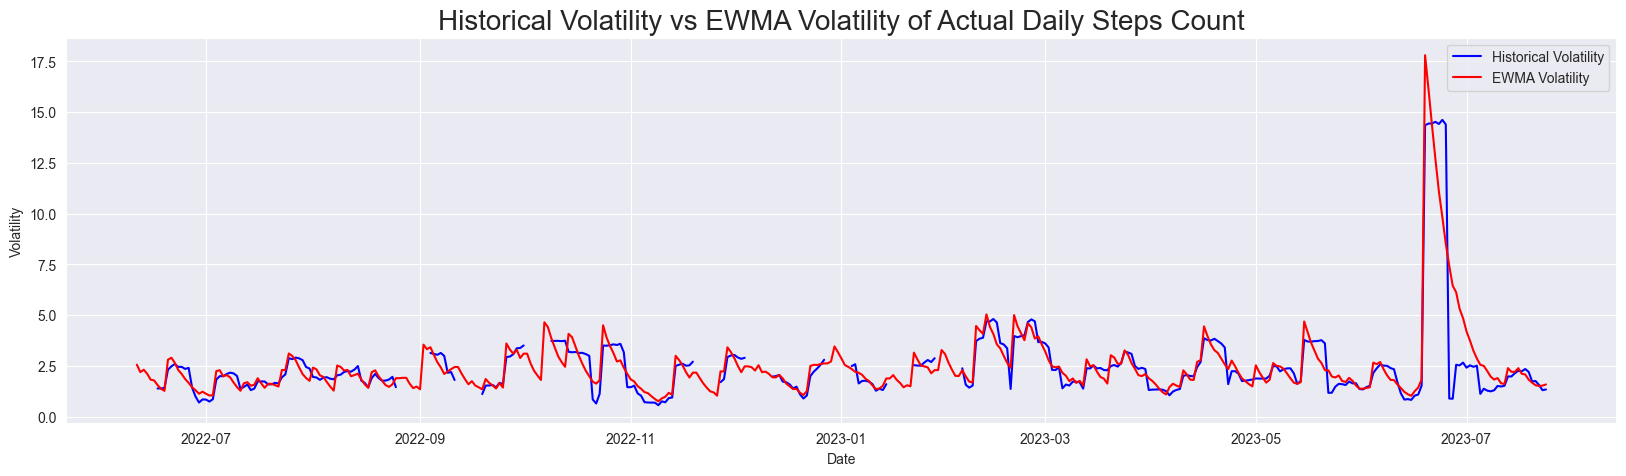

In [53]:
# Calculate daily percentage changes in steps
df['Step_Change'] = df['Actual'].pct_change().dropna()

window = 7  # 7-day window works better and the graph is prettier that way
df['Historical_Volatility'] = df['Step_Change'].rolling(window=window).std() * np.sqrt(window)

lambda_ = 0.94  # decay factor
df['EWMA_Volatility'] = df['Step_Change'].ewm(span=window, adjust=False, min_periods=window).std() * np.sqrt(window)


plt.figure(figsize=(20, 5))
plt.plot(df.index, df['Historical_Volatility'], label='Historical Volatility', color='blue')
plt.plot(df.index, df['EWMA_Volatility'], label='EWMA Volatility', color='red')
plt.title('Historical Volatility vs EWMA Volatility of Actual Daily Steps Count', fontsize=20)
# 
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

df.drop(columns=['Historical_Volatility', 'EWMA_Volatility', 'Step_Change' ], inplace=True)


### Lag plot
- A lag plot is a scatter plot where the values of the time series are plotted against lagged values of the same series. 
- This can help identify if the time series is autocorrelated (i.e., if past values influence future values). 
- A strong linear relationship in the plot suggests strong autocorrelation.

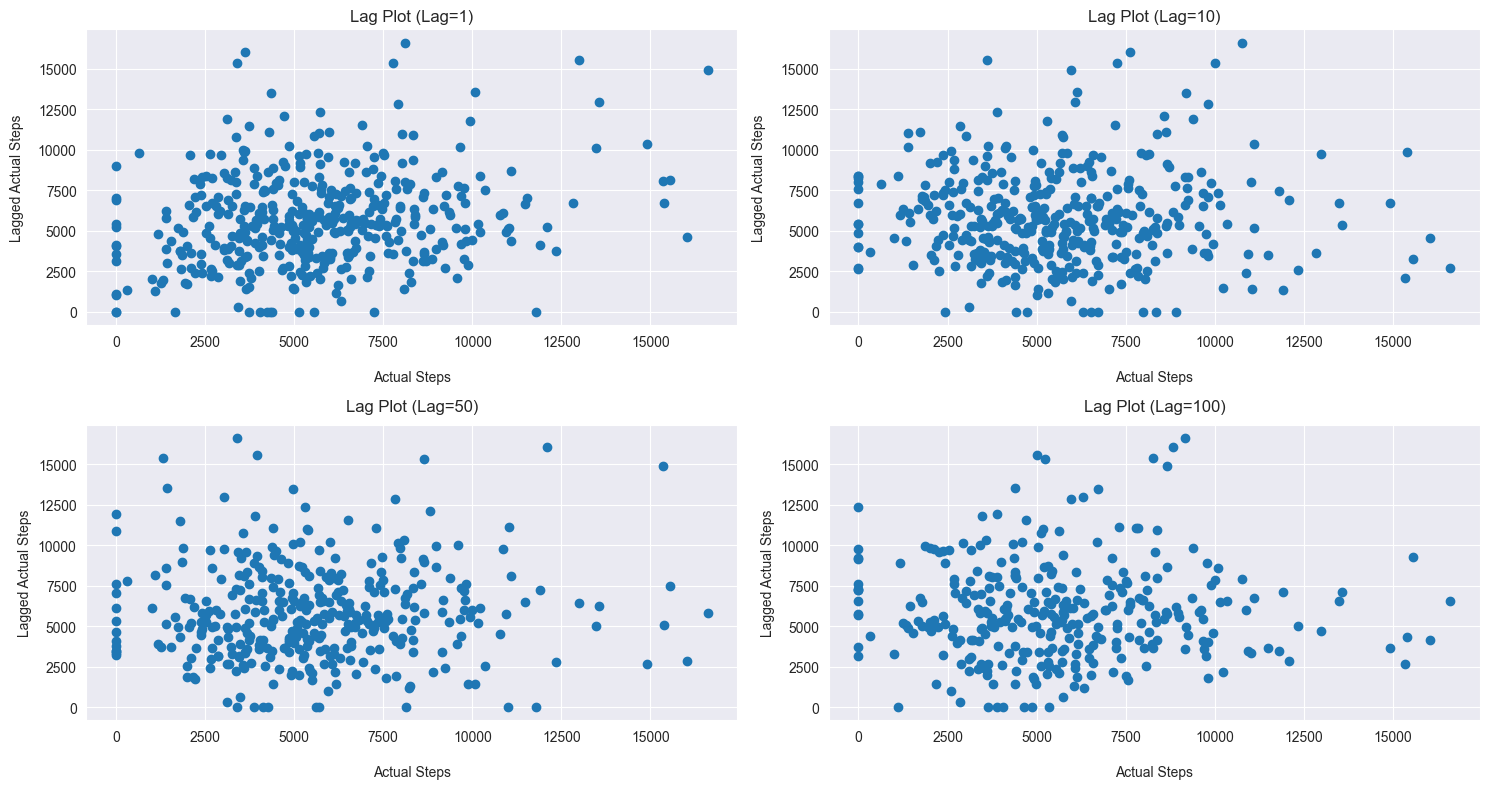

In [70]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
lag_plot(df['Actual'], lag=1)
plt.xlabel('Actual Steps', labelpad=15)
plt.ylabel('Lagged Actual Steps', labelpad=10)
plt.title('Lag Plot (Lag=1)')
# 
plt.subplot(2, 2, 2)
lag_plot(df['Actual'], lag=10)
plt.xlabel('Actual Steps', labelpad=15)
plt.ylabel('Lagged Actual Steps', labelpad=10)
plt.title('Lag Plot (Lag=10)')
# 
plt.subplot(2, 2, 3)
lag_plot(df['Actual'], lag=50)
plt.xlabel('Actual Steps', labelpad=15)
plt.ylabel('Lagged Actual Steps')
plt.title('Lag Plot (Lag=50)',  pad=10)
# 
plt.subplot(2, 2, 4)
lag_plot(df['Actual'], lag=100)
plt.xlabel('Actual Steps', labelpad=15)
plt.ylabel('Lagged Actual Steps')
plt.title('Lag Plot (Lag=100)', pad=10)

#
# plt.xlabel('Actual Steps')
# plt.ylabel('Lagged Actual Steps')
plt.tight_layout()
plt.show()


# models

# validation

### Lag Analysis

- Lag Plot: A scatter plot of the time series against a lagged version of itself, used to identify patterns and relationships.

### cross-correlation
- use this for avaluating testing data and predicted data
- Cross-Correlation: Measures the correlation between two time series at different lags, useful for identifying lead-lag relationships.

# compare model with world models

# reflective analysis
- whats i have learn from doing this assignment